#  Stock Predictions

What is the best model to predict stock prices?

In [1]:
# Loading the packages
if(!require("caret")){install.packages("caret")}
if(!require("tidyverse")){install.packages("tidyverse")}
if(!require("ISLR")){install.packages("ISLR")}
if(!require("boot")){install.packages("boot")}
if(!require("MASS") ){ install.packages("MASS") }
if(! require("leaps") ){ install.packages("leaps") }
if(! require("glmnet") ){ install.packages("glmnet") }
if(! require("pls") ){ install.packages("pls") }
if(! require("class") ){ install.packages("class") }
library(boot)
library(caret)
library(tidyverse)
library(ISLR)
library(MASS)
library(leaps)
library(glmnet)
library(pls)
library(class)


Loading required package: caret

Loading required package: lattice

Loading required package: ggplot2

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()

Loading required package: ISLR

Loading required package: boot


Attaching package: ‘boot’


The following object is masked from ‘package:lattice’:

    melanoma


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: leaps

Loading required package: glmnet

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are m

# Part 1: Dimensions Reduction

In [21]:
attach(Weekly)
summary(Weekly)
set.seed(1)

The following objects are masked from Weekly (pos = 3):

    Direction, Lag1, Lag2, Lag3, Lag4, Lag5, Today, Volume, Year




      Year           Lag1               Lag2               Lag3         
 Min.   :1990   Min.   :-18.1950   Min.   :-18.1950   Min.   :-18.1950  
 1st Qu.:1995   1st Qu.: -1.1540   1st Qu.: -1.1540   1st Qu.: -1.1580  
 Median :2000   Median :  0.2410   Median :  0.2410   Median :  0.2410  
 Mean   :2000   Mean   :  0.1506   Mean   :  0.1511   Mean   :  0.1472  
 3rd Qu.:2005   3rd Qu.:  1.4050   3rd Qu.:  1.4090   3rd Qu.:  1.4090  
 Max.   :2010   Max.   : 12.0260   Max.   : 12.0260   Max.   : 12.0260  
      Lag4               Lag5              Volume            Today         
 Min.   :-18.1950   Min.   :-18.1950   Min.   :0.08747   Min.   :-18.1950  
 1st Qu.: -1.1580   1st Qu.: -1.1660   1st Qu.:0.33202   1st Qu.: -1.1540  
 Median :  0.2380   Median :  0.2340   Median :1.00268   Median :  0.2410  
 Mean   :  0.1458   Mean   :  0.1399   Mean   :1.57462   Mean   :  0.1499  
 3rd Qu.:  1.4090   3rd Qu.:  1.4050   3rd Qu.:2.05373   3rd Qu.:  1.4050  
 Max.   : 12.0260   Max.   : 12.0

We would like to predict `Direction`, which denotes the direction of a stock's price on any given day. However, since there are many dependent variables, we would like to reduce it to only those that matters.

In [3]:
log.fit = glm(Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume,family = "binomial", data=Weekly)
summary(log.fit)


Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = "binomial", data = Weekly)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6949  -1.2565   0.9913   1.0849   1.4579  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.26686    0.08593   3.106   0.0019 **
Lag1        -0.04127    0.02641  -1.563   0.1181   
Lag2         0.05844    0.02686   2.175   0.0296 * 
Lag3        -0.01606    0.02666  -0.602   0.5469   
Lag4        -0.02779    0.02646  -1.050   0.2937   
Lag5        -0.01447    0.02638  -0.549   0.5833   
Volume      -0.02274    0.03690  -0.616   0.5377   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1496.2  on 1088  degrees of freedom
Residual deviance: 1486.4  on 1082  degrees of freedom
AIC: 1500.4

Number of Fisher Scoring iterations: 4


The function has perform a t-test for every dependent variable, whose results are shown in the Pr(>|z|) column. It is testing between 2 hypotheses: 
    1. Hypothesis 0: The dependent variable's coefficient **MIGHT BE** 0, i.e. this variable is not significant.
                     In this case, p-value > significance level
                     
    2. Hypothesis 1: The dependent variable's coefficient **IS NOT** be 0. i.e this variable is significant.
                     In this case, p-value < significance level.

Choosing a reasonable significance level of 0.05, we can see that only `Lag2` is statistically significant.
Therefore, moving forward, we will use `Lag2` to predict `Direction`

Below, we create a function to help us understand how each model perform.

# Part 2: Comparing Models

In [93]:
show_model_performance <- function(prediction, observation) {
    confusion_matrix <- table(prediction, 
                            observation, 
                            dnn = c("Pred", "Obs"))
    print(confusion_matrix)

    err <- mean(prediction != observation)

    cat("\n") # \n means newline so it just prints a blank line
    cat("             Error:", 100 * err, "%\n")
    cat("Correct Prediction:", 100 * (1-err), "%\n\n")
    cat("     True Positive:", 100 * confusion_matrix[2,1] / sum(confusion_matrix[,2]), "%\n")
    cat("    False Positive:", 100 * confusion_matrix[2,1] / sum(confusion_matrix[,1]), "%\n\n")
    cat("     True Negative:", 100 * confusion_matrix[1,2] / sum(confusion_matrix[,1]), "%\n")
    cat("    False Negative:", 100 * confusion_matrix[1,2] / sum(confusion_matrix[,2]), "%\n")
}

predict_glm_direction <- function(model, newdata = NULL) {
  predictions <- predict(model, newdata, type="response")
  return(as.factor(ifelse(predictions < 0.5, "Down", "Up")))
}

correct_rate <- function(prediction, observation) {
    err <- mean(prediction != observation)
    return (100 * (1-err))
}

## Model 1: Comprehesive Logistic Regression
To demonstrate why using all variables is undesirable compared to only statistically significant ones, we compare 2 logistic models: Model 1 with all variables as predictor, and Model 2 with only Lag2 as predictor

In [94]:
log.probs = predict(log.fit, type="response")
log.preds = rep("Down", 1089)
log.preds[log.probs > 0.5] = "Up"

show_model_performance(log.preds, Direction)

      Obs
Pred   Down  Up
  Down   54  48
  Up    430 557

             Error: 43.89348 %
Correct Prediction: 56.10652 %

     True Positive: 71.07438 %
    False Positive: 88.84298 %

     True Negative: 9.917355 %
    False Negative: 7.933884 %


## Results for: Log model
### Correct Rate: 56%
An above 50% correct rate is certainly desirable for long-term investment. Though this model is very good at predicting upward trends, it is terrible at predicting downward trends. Besides, False rates suggest that this model is biased toward positive direction.

## Model 2: Logistic regression with statistically significant predictors
In this model, we will split our dataset into training and testing. Data before 2009 will be used to train, and we will predict data in 2009 and 2010.

In [95]:
train <- (Weekly$Year < 2009)
train_set <- Weekly[train, ]
test_set <- Weekly[!train, ]

logit_model <- glm(Direction ~ Lag2, data = Weekly, family = binomial, subset = train)

predicted_direction <- predict_glm_direction(logit_model, test_set)
show_model_performance(predicted_direction, test_set$Direction)

      Obs
Pred   Down Up
  Down    9  5
  Up     34 56

             Error: 37.5 %
Correct Prediction: 62.5 %

     True Positive: 55.7377 %
    False Positive: 79.06977 %

     True Negative: 11.62791 %
    False Negative: 8.196721 %


## Results for: Log model with only Lag2
### Correct Rate: 62.5%
By removing statistically insignificant predictors, we have improved the correct rate by 6.5%. However, this model still suffers from the same issue as before: heavy bias toward upward trend.

## Model 3: Linear Discriminant Analysis

In [96]:
lda_model <- lda(Direction ~ Lag2, data = Weekly, subset = train)

predictions <- predict(lda_model, test_set, type="response")
show_model_performance(predictions$class, test_set$Direction)

      Obs
Pred   Down Up
  Down    9  5
  Up     34 56

             Error: 37.5 %
Correct Prediction: 62.5 %

     True Positive: 55.7377 %
    False Positive: 79.06977 %

     True Negative: 11.62791 %
    False Negative: 8.196721 %


## Results for: LDA
### Correct Rate: 62.5%
LDA produces the same results as Logistic Model with Lag2. Though this might seems unusual, this is actually not unprecedented since they are both quite similar. 

## Model 4: Quadratic Discriminant Analysis

In [97]:
qda_model <- qda(Direction ~ Lag2, data = Weekly, subset = train)

predictions <- predict(qda_model, test_set, type="response")
show_model_performance(predictions$class, test_set$Direction)

      Obs
Pred   Down Up
  Down    0  0
  Up     43 61

             Error: 41.34615 %
Correct Prediction: 58.65385 %

     True Positive: 70.4918 %
    False Positive: 100 %

     True Negative: 0 %
    False Negative: 0 %


## Results for: QDA
### Correct Rate: 58%
With no downward predictions, this seems to be an over-optimistic and terrible model. QDA is a very flexible model, which might have led it to overgeneralize all data points into a single group as it attempts to fit to outliers. And as we know that the stock market tends to be very unpredictable from day to day, this seems to be a logical conslusion.

However, at 58%, this model is BETTER than comprehensive logistic model (model 1) at 56%. What do we learn?
We learn 2 things:
    1. Including insignificant predictors in your models not only complicates things, but also makes your model worse
    2. If you assume that the market's value will rise everyday, without doing any calculations, you would be right 58% of the time!
    
What does point 2. entail? It entails a stock trading strategy that has been proven to be successful for hundreds of years: Buy-and-Hold. If you buy a share and keep it for as long as you can, you would likely make profits. 

In our case, we are monitoring the general value of the market, which suggests that buying ETFs and holding them is a very effective strategy.

## Model 5: K-nearest Neighbors

In [154]:
run_knn <- function(train, test, train_class, test_class, k) {
    set.seed(1)
    predictions <- knn(train, test, train_class, k)

    cat("KNN: k =", k, "\n")
    show_model_performance(predictions, test_class)
}

We first attempts to find the best K value. We test each K value from 1 to 300 to see which provide the best test accuracy.

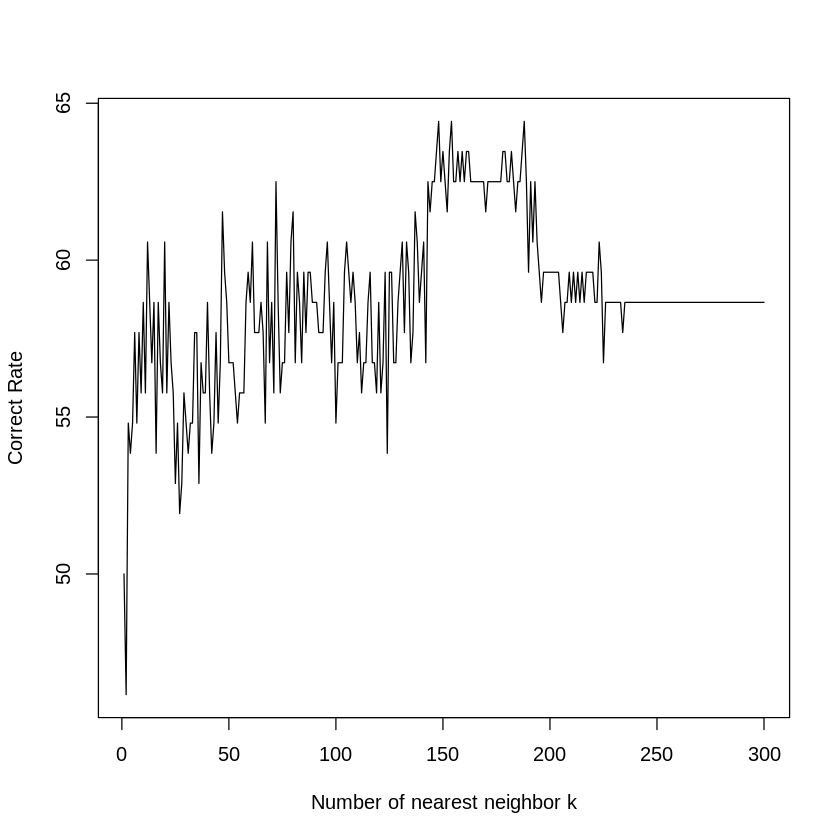

In [173]:
knn_array <- rep(NA, 300)
for (k in 1:300) {
    predictions <- knn(train_matrix, test_matrix, train_set$Direction, k)
    knn_array[k] <- correct_rate(predictions, test_set$Direction)
}
plot(1:300, knn_array, xlab = "Number of nearest neighbor k", ylab = "Correct Rate", type = "l")


In [166]:
for (i in 100:160){
    max_knn <- max(knn_array)
    if (knn_array[i] == max_knn){
        cat("KNN has the highest correct rate = ", max_knn,"%", "at k = ", i + 1, "\n")
        break
    }
}


KNN has the highest correct rate =  64.42308 % at k =  154 


In [171]:
train_matrix <- as.matrix(train_set$Lag2)
test_matrix <- as.matrix(test_set$Lag2)

run_knn(train_matrix, test_matrix, train_set$Direction, test_set$Direction, k = 154)

KNN: k = 154 
      Obs
Pred   Down Up
  Down   10  4
  Up     33 57

             Error: 35.57692 %
Correct Prediction: 64.42308 %

     True Positive: 54.09836 %
    False Positive: 76.74419 %

     True Negative: 9.302326 %
    False Negative: 6.557377 %


In [172]:
run_knn(train_matrix, test_matrix, train_set$Direction, test_set$Direction, k = 1)

KNN: k = 1 
      Obs
Pred   Down Up
  Down   21 30
  Up     22 31

             Error: 50 %
Correct Prediction: 50 %

     True Positive: 36.06557 %
    False Positive: 51.16279 %

     True Negative: 69.76744 %
    False Negative: 49.18033 %


## Results for: KNN
### Correct Rate: 64.42%
Looking at the KNN comparison graph, we can see that the best k value is around 150. We have calculated to identify
k = 154 maximizes Correct Prediction. We also see that smaller k value (less than 100) does not provide a good model. This might be explained that more flexible models might not be good at predicting the stock market since it is volatile.

On the other hand, k = 154 suffers from the same issue with other inflexible models: low correct rate on negative direction. k = 1 produces significantly better prediction for negative directions than any other tested model, albeit it at the cost of producing the lowest overall accuracy.

# Part 3: What do we learn?

1. Less is More. Including statistically insignificant varibles in your model makes it worse
2. For predicting stock market, KNN with k = 154 provides good predictions
3. More flexible methods are not as good as inflexible ones in predicting the stock market
4. Buy-and-Hold is backed by statistics to be a legit trading stradegy!